we start by importing the necessary libraries that we are going to use through the process of understanding how stocks trading works for Amazon (AMZN).
## AMAZON (AMZN)

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import dash
from dash import dcc , html
from dash.dependencies import Input,Output,State
import plotly.graph_objects as go
import plotly.express as px

In this project I am going to use Alpha Vantage which is a website that gives free Stock APIS in JSON or Excel

I started by (obviously) giving the apikey,constructing the url by adding the trading symbol and requesting the file

In [2]:
api_key = '2TOAZEEQODFWG9FF'
amazonSymbol='AMZN'
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={amazonSymbol}&apikey={api_key}'
response = requests.get(url)

In [3]:
#checking if we got a reponse by testing the status code
if response.status_code == 200:
    amazonjsonfile = response.json()
    time_series = amazonjsonfile.get('Time Series (Daily)', {})
    amazonlist = [{'Date': date, 'Open': values.get('1. open', 'N/A'),
                  'High': values.get('2. high', 'N/A'), 'Low': values.get('3. low', 'N/A'),
                  'Close': values.get('4. close', 'N/A'), 'Volume': values.get('5. volume', 'N/A')}
                 for date, values in time_series.items()]
    amazonDf = pd.DataFrame(amazonlist)

else:
    print("Error generated,Try again!")

##### Cleaning Data
as we examine the type of data we have by using:amazonDf.info() we notice that the data type is object so we have to cast these types in order to be used in data analysis and visualization.

In [4]:
amazonDf['Date']=pd.to_datetime(amazonDf['Date'])
#aggregating dates in a Day column
amazonDf['Open'] = pd.to_numeric(amazonDf['Open'],errors='coerce')
amazonDf['High'] = pd.to_numeric(amazonDf['High'],errors='coerce')
amazonDf['Low'] = pd.to_numeric(amazonDf['Low'],errors='coerce')
amazonDf['Close'] = pd.to_numeric(amazonDf['Close'],errors='coerce')
amazonDf['Volume'] = pd.to_numeric(amazonDf['Volume'],errors='coerce')

We start by visualizing the distribution of trade volumes over time to identify the significant market moment by pointing out the high trading volume that indicate an increased market activity,reasonable stocks'prices..etc

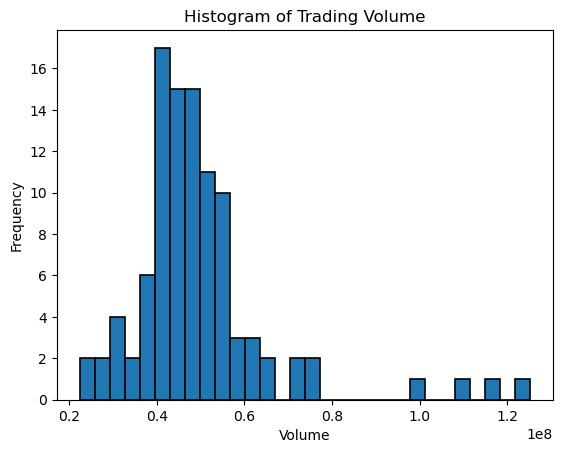

In [5]:
plt.hist(amazonDf['Volume'],bins=30,edgecolor='black', linewidth=1.2)
plt.title('Histogram of Trading Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.show()

Now we move to representing the RSI(Relative Strength Index) that indicates wether the amazonStock is oversold or overbought.

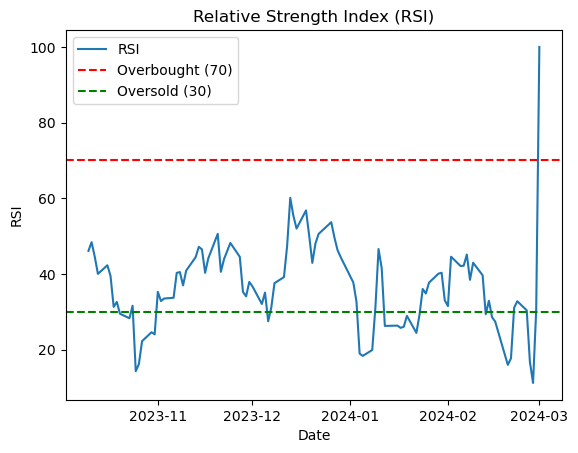

In [7]:
n = 14
diff = amazonDf['Close'].diff()
gain = diff.where(diff > 0, 0)
loss = -diff.where(diff < 0, 0)

avg_gain = gain.rolling(window=n, min_periods=1).mean()
avg_loss = loss.rolling(window=n, min_periods=1).mean()
RSI = 100 - (100 / (1 + (avg_gain / avg_loss)))

plt.plot(amazonDf['Date'], RSI, label='RSI')
#we represent an horizontal line where RSI=70 and another when RSI=30 in order to easily analyse the RSI 
plt.axhline(y=70, color='r',linestyle="--", label='Overbought (70)')
plt.axhline(y=30, color='g',linestyle="--", label='Oversold (30)')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.show()

Now let's analyze the graph we got:

### from 09/2023 to 10/2023: 
The RSI was between 30 and 70 means that it is neutral and the trader must rely on other aspects
### from 10/2023 to 11/2023 and from 12/2023 to 02/2024:
The RSI<30,in this case the investor should consider buying since the prices will increase.
### from 11/2023 to 12/2023:
the RSI>70,in this case the investor should consider selling since the prices will decline.


Now we move to visualizing our data,we create a new column 'Return' where we have the % change in open prices from one row to the next.This column will be used in calculating volatility over time using rolling function and specifying the number of windows(Each 4 values we calculate the average value using mean)

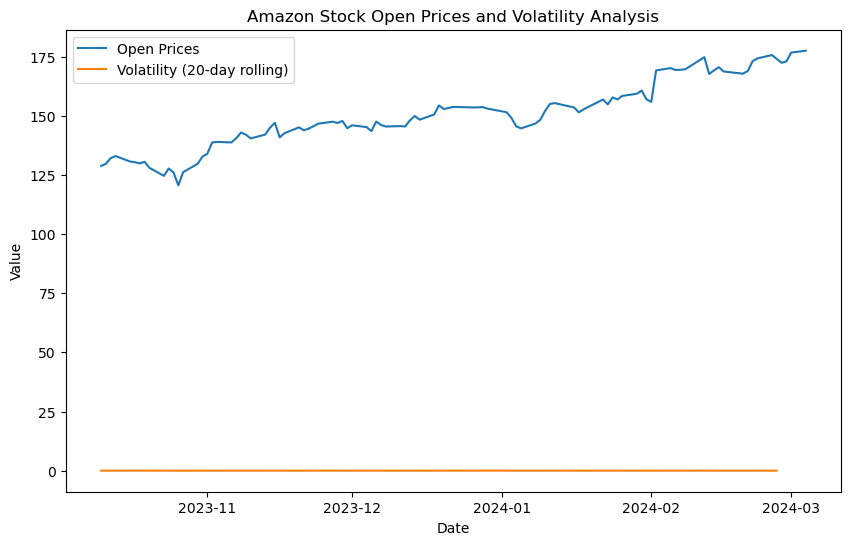

In [8]:
amazonDf['Return'] = amazonDf['Open'].pct_change()
rolling_volatility = amazonDf['Return'].rolling(window=4).mean()
fig=plt.figure(figsize=(10, 6))
plt.plot(amazonDf['Date'], amazonDf['Open'], label='Open Prices')
plt.plot(amazonDf['Date'], rolling_volatility, label='Volatility (20-day rolling)')
plt.title('Amazon Stock Open Prices and Volatility Analysis')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


we can conclude that having or horizontal line in the volatility graph(overall) means that the stock's price changes are not experiencing large swings (stable) and also the open prices are getting higher with time which is expected for an enormous company like Amazon.

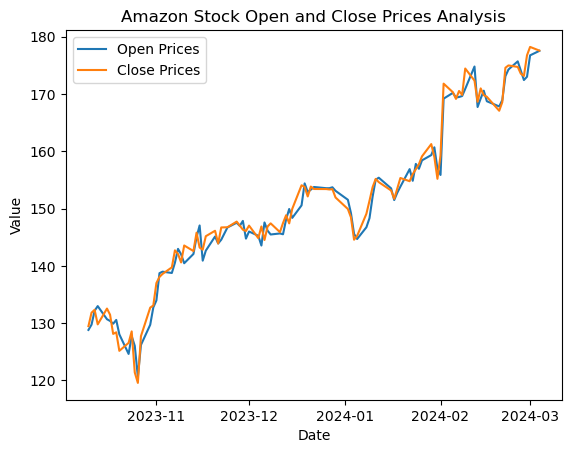

In [9]:
plt.plot(amazonDf['Date'], amazonDf['Open'], label='Open Prices')
plt.plot(amazonDf['Date'], amazonDf['Close'], label='Close Prices')
plt.title('Amazon Stock Open and Close Prices Analysis')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

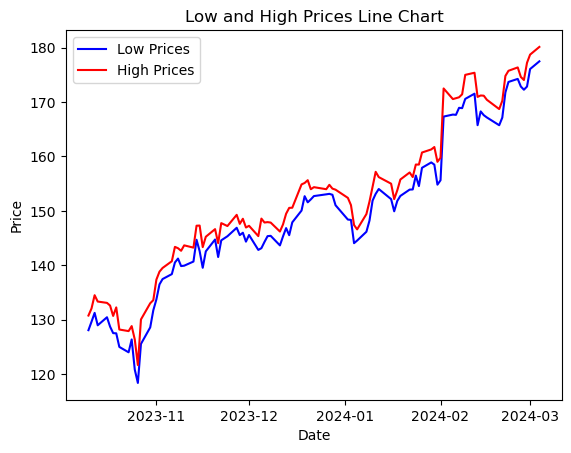

In [10]:
plt.plot(amazonDf['Date'], amazonDf['Low'], label='Low Prices', color='blue')
plt.plot(amazonDf['Date'], amazonDf['High'], label='High Prices', color='red')
plt.title('Low and High Prices Line Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

We notice that basically the open and close prices are very close which means that the chance of a stock being sold with lower price than the open one is low and same conclusion for high and low prices.

#### Creating a simple dashboard using Dash and Plotly:

In [11]:
app=dash.Dash(__name__)
amaznLogo='https://cdn.freebiesupply.com/images/large/2x/amazon-logo-transparent.png'
# creating the graphs that I want to include in my dashboard
#low x high prices
lowPlot=px.line(data_frame=amazonDf,title='Variation of low stock prices',x='Date',y='Low')
highPlot=px.line(data_frame=amazonDf,title='Variation of High stock prices',x='Date',y='High')
lowXhigh = go.Figure(data=highPlot.data + lowPlot.data)
lowXhigh.update_layout(xaxis_title='Date', yaxis_title='Price')
#close x open prices
closePlot=px.line(data_frame=amazonDf,x='Date',y='Close')
openPlot=px.line(data_frame=amazonDf,x='Date',y='Open')
closeXopen=go.Figure(data=closePlot.data + openPlot.data)
closeXopen.update_layout(xaxis_title='Date', yaxis_title='Price')
#volatility (adding it as a columun to facilite it use)
amazonDf['rolling_volatility']=rolling_volatility
volatilityPlot=px.line(amazonDf,x='Date',y='rolling_volatility')

#RSI
amazonDf['RSI']=RSI
RsiPlot=px.line(amazonDf,amazonDf['Date'],RSI)

#Pie where I represent the variation of the RSI between 70 and 30
Rsioversold=0
Rsineutral=0
Rsioverbought=0
for index, row in amazonDf.iterrows():
    if row['RSI']<30:
        Rsioversold+=1
    elif 30<row['RSI']<70:
        Rsineutral+=1
    else:
        Rsioverbought+=1
s=Rsioversold+Rsineutral+Rsioverbought
pieRSI = pd.DataFrame({
    'Category': ['<30:Oversold', '30-70:Neutral', '>70:Overbought'],
    'Count': [(Rsioversold/s)*100, (Rsineutral/s)*100, (Rsioverbought/s)*100]
})
pieRSI0 = px.pie(pieRSI, values='Count', names='Category')

#Visualizing the volume
volumePlot=px.line(data_frame=amazonDf,title='Variation of volume',x='Date',y='Volume')
#now for the app
app = dash.Dash(__name__)
app.layout = html.Div([
    html.Img(src=amaznLogo, style={'display': 'block', 'width': '250px', 'margin': 'auto'}),
    html.H2('AMAZON Stocks Trading', style={'display': 'block', 'width': '250px', 'margin': 'auto'}),
    html.H3('Symbol:AZMN', style={'display': 'block', 'width': '250px', 'margin': 'auto'}),
    html.Hr(),
    html.Div([
        html.Div([
            html.H2('Why comparing Low to High stock prices?', style={'text-align': 'center'}),
            html.P('It is crucial for investors to analyze the market trends and identify potential opportunities or risks. Low prices may signify undervalued assets, offering investment prospects, while high prices could indicate overvaluation. This comparison helps investors make informed decisions, manage risk, and adapt strategies to changing market conditions.', style={'text-align': 'center'}),
        ], style={'display': 'inline-block', 'width': '50%', 'margin-top': '120px'}),
        html.Div([
            dcc.Graph(figure=lowXhigh, style={'display': 'inline-block'})
        ], style={'display': 'inline-block', 'width': '50%'})
    ], style={'display': 'flex'}),
    html.Div([
        html.Div([
            html.H2('Why comparing open to close stock prices?', style={'text-align': 'center'}),
            html.P('It helps investors assess the price movement within a trading day, providing insights into market sentiment, volatility, and whether a stock closed higher or lower than it opened.', style={'text-align': 'center'}),
        ], style={'display': 'inline-block', 'width': '50%', 'margin-top': '120px'}),
        html.Div([
            dcc.Graph(figure=closeXopen, style={'display': 'inline-block'})
        ], style={'display': 'inline-block', 'width': '50%'})
    ], style={'display': 'flex'}),
    html.Div([
        html.Div([
            html.H2('Why identifying Volatility?', style={'text-align': 'center'}),
            html.P('It is Crucial for investors as it measures the degree of price fluctuations in the market. High volatility implies greater risk and potential returns, while low volatility may indicate a more stable environment', style={'text-align': 'center'}),
        ], style={'display': 'inline-block', 'width': '50%', 'margin-top': '120px'}),
        html.Div([
            dcc.Graph(figure=volatilityPlot, style={'display': 'inline-block', 'width': '100%'})
        ], style={'display': 'inline-block', 'width': '50%'})
    ], style={'display': 'flex'}),
    html.Div([
        html.Div([
            html.H2('Why identifying RSI(Relative Strength Index)?', style={'text-align': 'center'}),
            html.P('RSI is a tool to see if a stock is trading a lot or a little. It helps decide when to buy or sell by showing how fast prices are changing. Its like a signal for whether an investment is strong or weak.', style={'text-align': 'center'}),
        ], style={'display': 'inline-block', 'width': '50%', 'margin-top': '120px'}),
        html.Div([
            dcc.Graph(figure=RsiPlot, style={'display': 'inline-block', 'width': '100%'})
        ], style={'display': 'inline-block', 'width': '50%'})
    ], style={'display': 'flex'}),
    html.Div([
        html.Div([
            html.H2('Why classifying RSI values?', style={'text-align': 'center'}),
            html.P('It simplifies decision-making by providing clear signals for possible trends and reversals.', style={'text-align': 'center'}),
            html.Ul('when RSI is low (<30):potential buying opportunities.'),
            html.Ul('a neutral zone (30-70):it indicates stable market conditions'),
            html.Ul('when RSI is high (>70):potential selling opportunities'),
        ], style={'display': 'inline-block', 'width': '50%', 'margin-top': '120px'}),
        html.Div([
            dcc.Graph(figure=pieRSI0, style={'display': 'inline-block', 'width': '80%'})
        ], style={'display': 'inline-block', 'width': '50%'})
    ], style={'display': 'flex'}),
    html.Div([
        html.H2('The variation of volume,close and open'),
        dcc.DatePickerRange(
            id='datePicker',
            min_date_allowed=amazonDf['Date'].min(),
            max_date_allowed=amazonDf['Date'].max(),
            initial_visible_month=amazonDf['Date'].min()
        ),
        html.Div([
            dcc.Graph(id='openPlot', figure=openPlot),
            dcc.Graph(id='closePlot', figure=closePlot),
            dcc.Graph(id='volumePlot', figure=volumePlot),
        ])
    ])
])

# Callback to visualize the interactive date range slider
@app.callback(
    [dash.dependencies.Output('openPlot', 'figure'),
     dash.dependencies.Output('closePlot', 'figure'),
     dash.dependencies.Output('volumePlot', 'figure')],
    [dash.dependencies.Input('datePicker', 'start_date'),
     dash.dependencies.Input('datePicker', 'end_date')]
)
def update_graphs(start_date, end_date):
    if start_date is None or end_date is None:
        return px.line(amazonDf, x='Date', y='Open'), px.line(amazonDf, x='Date', y='Close'), px.line(amazonDf, x='Date', y='Volume')
    else:
        amazonDfFiltered = amazonDf[(amazonDf['Date'] >= start_date) & (amazonDf['Date'] <= end_date)]
        return px.line(amazonDfFiltered, x='Date', y='Open'), px.line(amazonDfFiltered, x='Date', y='Close'), px.line(amazonDfFiltered, x='Date', y='Volume')

if __name__ == '__main__':
    app.run_server(debug=True)